Data source : https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_validate, StratifiedKFold, GridSearchCV, KFold , cross_val_score , cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score , roc_curve , precision_recall_curve, auc

In [34]:
import pickle

In [3]:
data = pd.read_csv("ai4i2020.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [5]:
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Split the data into train and two test sections.  

In [6]:
## Split data into train and test set .
test_0 = data[data['Machine failure'] == 0].sample(frac = 0.1, random_state = 1)
test_1 = data[data['Machine failure'] == 1].sample(frac = 0.1, random_state = 1)
test_data_1 = pd.concat([test_0 , test_1])
test_data_1.shape

(1000, 14)

In [7]:
test_data_1['Machine failure'].value_counts()

0    966
1     34
Name: Machine failure, dtype: int64

In [8]:
bal_data = data[~data.index.isin(test_data_1.index.tolist())]
##
test_0 = bal_data[bal_data['Machine failure'] == 0].sample(frac = 0.1, random_state = 12)
test_1 = bal_data[bal_data['Machine failure'] == 1].sample(frac = 0.1, random_state = 12)
test_data_2 = pd.concat([test_0 , test_1])
test_data_2.shape

(900, 14)

In [9]:
test_data_2['Machine failure'].value_counts()

0    870
1     30
Name: Machine failure, dtype: int64

In [10]:
train_data = bal_data[~bal_data.index.isin(test_data_2.index.tolist())]
print(train_data.shape)

(8100, 14)


In [11]:
train_data['Type'].value_counts()

L    4885
M    2423
H     792
Name: Type, dtype: int64

In [12]:
train_data['Machine failure'].value_counts()

0    7825
1     275
Name: Machine failure, dtype: int64

In [13]:
twf = train_data['TWF'].value_counts()
twf

0    8063
1      37
Name: TWF, dtype: int64

In [14]:
hdf = train_data['HDF'].value_counts()
hdf

0    8007
1      93
Name: HDF, dtype: int64

In [15]:
pwf = train_data['PWF'].value_counts()
pwf

0    8022
1      78
Name: PWF, dtype: int64

In [16]:
osf = train_data['OSF'].value_counts()
osf

0    8023
1      77
Name: OSF, dtype: int64

In [17]:
rnf = train_data['RNF'].value_counts()
rnf

0    8084
1      16
Name: RNF, dtype: int64

In [18]:
twf[twf.index ==1] + hdf[hdf.index ==1] + pwf[pwf.index ==1] + osf[osf.index ==1] + rnf[rnf.index ==1]

1    301
dtype: int64

Combined Failure is 301 which is greater than 275 indicating that for some cases there are multiple failures that  have occured in more than one types.  

In [19]:
failure_pct = (train_data[train_data['Machine failure'] ==1].shape[0]/train_data.shape[0])*100
failure_pct

3.3950617283950617

In [20]:
print("Unbalanced data set with {}% machine failures. ".format(failure_pct))

Unbalanced data set with 3.3950617283950617% machine failures. 


Distribution of the numeric variables.  

In [21]:
cols = train_data. columns.tolist()

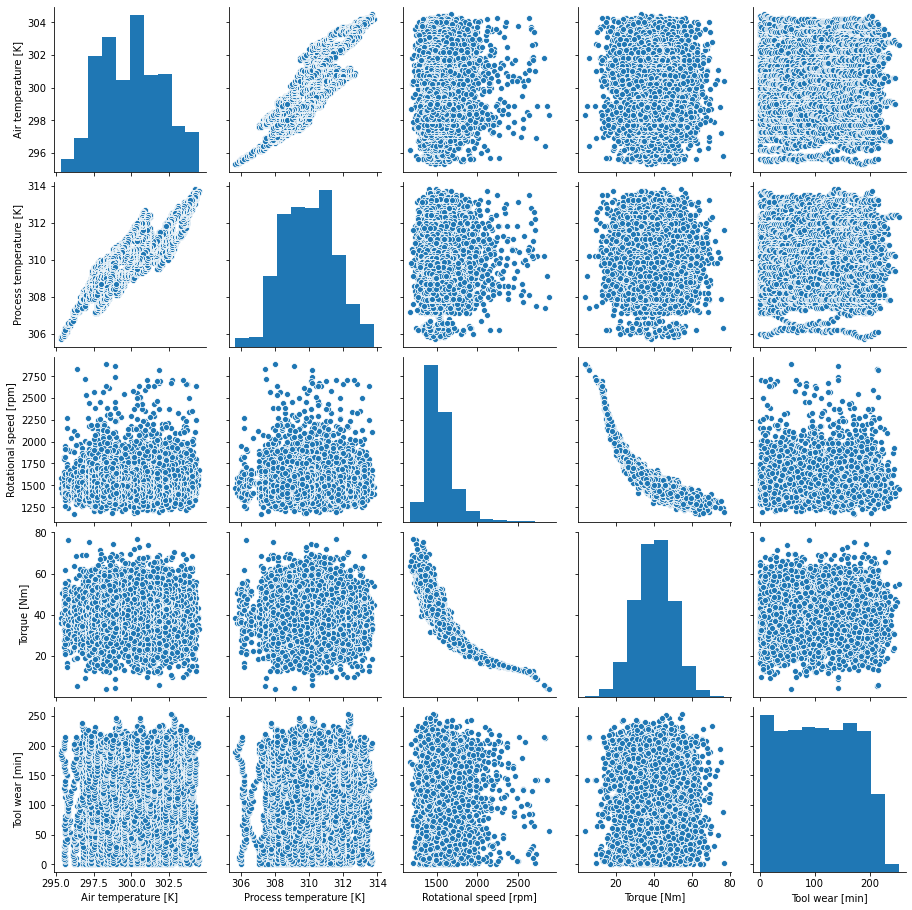

In [22]:
sns.pairplot(train_data[cols[3:8]])

Except for Rotational speed , the numeric variables have a near gaussian distribution.  
Process temparature and air temperature show linearity and positive correlation.
Torque and Rotational speed some show linearity and negative correlation.  

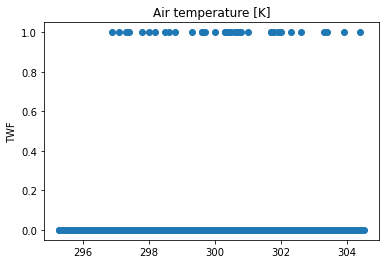

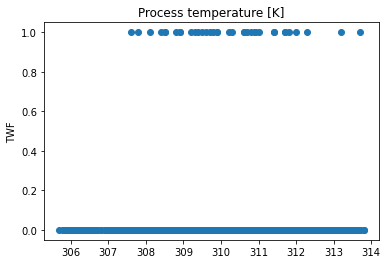

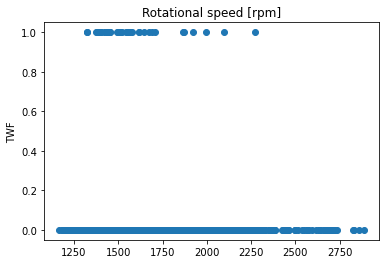

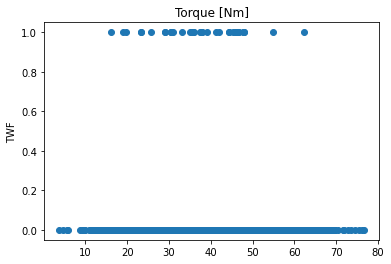

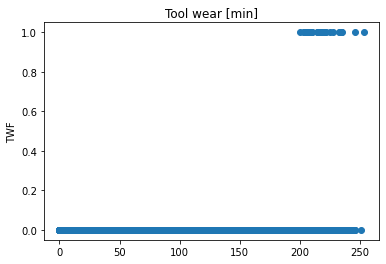

In [23]:
## Plot the failures against the predictor variables.
for i in range(3,8):
    plt.figure()
    plt.scatter(train_data[cols[i]], train_data['TWF'])
    plt.title(cols[i])
    plt.ylabel('TWF')

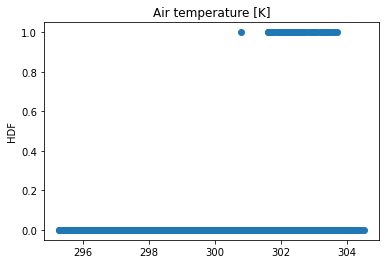

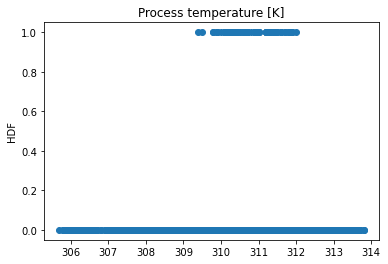

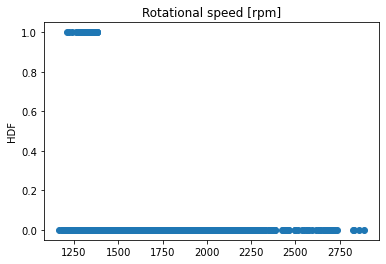

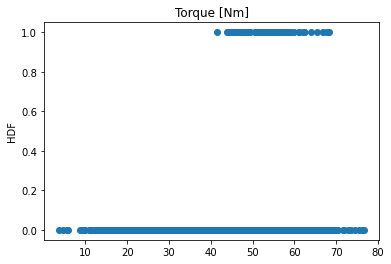

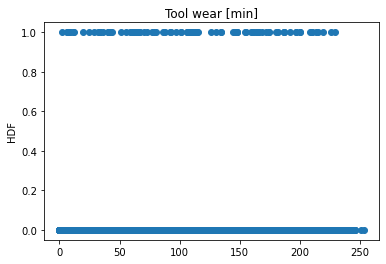

In [24]:
## Plot the failures against the predictor variables.
for i in range(3,8):
    plt.figure()
    plt.scatter(train_data[cols[i]], train_data['HDF'])
    plt.title(cols[i])
    plt.ylabel('HDF')

In [25]:
predictors = train_data[['Air temperature [K]','Rotational speed [rpm]','Tool wear [min]']]
X_test_1 = test_data_1[['Air temperature [K]','Rotational speed [rpm]','Tool wear [min]']]
y_test_1 = test_data_1['Machine failure']
target = train_data['Machine failure']
## Since the temparature variables are corelated and torque and rotational speed are too , include one of them in the model.

X_train, X_validation, y_train, y_validation = train_test_split(predictors, target , stratify = target , test_size = 0.15, random_state = 12)
print("Train data size :{}".format(X_train.shape))
print("Validation data size :{}".format(X_validation.shape))
print("Test data size :{}".format(X_test_1.shape))

Train data size :(6885, 3)
Validation data size :(1215, 3)
Test data size :(1000, 3)


In [26]:
y_train.value_counts()

0    6651
1     234
Name: Machine failure, dtype: int64

In [27]:
## Scale the input variables
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test_1)

In [28]:
X_test_scaled

array([[0.94565217, 0.17345751, 0.32806324],
       [0.88043478, 0.20838184, 0.14624506],
       [0.32608696, 0.29860303, 0.76679842],
       ...,
       [0.7826087 , 0.08090803, 0.33992095],
       [0.91304348, 0.11350407, 0.35573123],
       [0.7173913 , 0.09487776, 0.33596838]])

In [29]:
lg = LogisticRegression()
model = lg.fit(X_train_scaled,y_train)
train_pred = model.predict(X_train_scaled)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix for train data : \n")
print(confusion_matrix(y_train,train_pred))
print("Confusion matrix for validation data : \n")
print(confusion_matrix(y_validation,validation_pred))

Confusion matrix for train data : 

[[6651    0]
 [ 234    0]]
Confusion matrix for validation data : 

[[1174    0]
 [  41    0]]


Confusion matrix : 

[[966   0]
 [ 34   0]]
Classification report : 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.00      0.00      0.00        34

    accuracy                           0.97      1000
   macro avg       0.48      0.50      0.49      1000
weighted avg       0.93      0.97      0.95      1000



/Users/anushabanninthaya/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


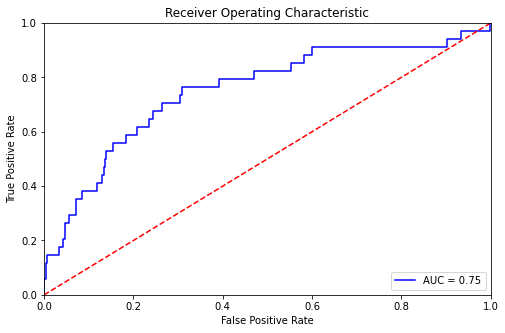

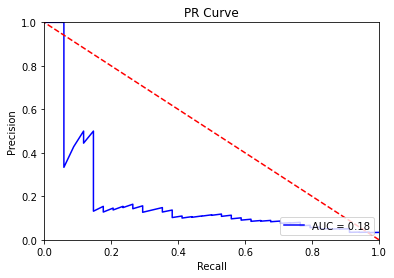

In [30]:
## On Test data 
## Calculate the AUC and plot the ROC curve.
test_pred = model.predict(X_test_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_test_1,test_pred))
print("Classification report : \n")
print(classification_report(y_test_1,test_pred))
test_prob = model.predict_proba(X_test_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_test_1, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [31]:
## Record the results
classifier  = ['Logistic Regression']
pr = [0]
rc = [0]
f1_score = [0]

Set values for non parametric models:

In [32]:
predictors = train_data[cols[3:8]]
X_test_1 = test_data_1[cols[3:8]]
y_test_1 = test_data_1['Machine failure']
target = train_data['Machine failure']
## Since the temparature variables are correlated and torque and rotational speed are too , include one of them in the model.

X_train, X_validation, y_train, y_validation = train_test_split(predictors, target , stratify = target , test_size = 0.15, random_state = 12)
print("Train data size :{}".format(X_train.shape))
print("Validation data size :{}".format(X_validation.shape))
print("Test data size :{}".format(X_test_1.shape))

Train data size :(6885, 5)
Validation data size :(1215, 5)
Test data size :(1000, 5)


In [33]:
## Scale the input variables
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test_1)

In [35]:
## save the scaler
pickle.dump(scaler, open('minmax_scaler.sav' , 'wb'))

In [39]:
X_train_scaled

array([[0.90217391, 0.81481481, 0.58207218, 0.19198895, 0.86561265],
       [0.85869565, 0.7037037 , 0.10535506, 0.65331492, 0.03557312],
       [0.2173913 , 0.35802469, 0.24214203, 0.35359116, 0.55731225],
       ...,
       [0.65217391, 0.61728395, 0.21420256, 0.49033149, 0.12252964],
       [0.60869565, 0.7654321 , 0.08265425, 0.72237569, 0.13833992],
       [0.26086957, 0.34567901, 0.32130384, 0.36049724, 0.83003953]])

In [40]:
X_validation_scaled

array([[0.39130435, 0.44444444, 0.24039581, 0.37154696, 0.256917  ],
       [0.86956522, 0.80246914, 0.16821886, 0.50966851, 0.18972332],
       [0.40217391, 0.55555556, 0.2991851 , 0.34530387, 0.19367589],
       ...,
       [0.58695652, 0.60493827, 0.23515716, 0.47928177, 0.19762846],
       [0.22826087, 0.32098765, 0.31315483, 0.37430939, 0.03557312],
       [0.31521739, 0.32098765, 0.03608847, 0.77071823, 0.64031621]])

In [41]:
X_test_scaled

array([[0.94565217, 0.91358025, 0.17345751, 0.49309392, 0.32806324],
       [0.88043478, 0.87654321, 0.20838184, 0.37292818, 0.14624506],
       [0.32608696, 0.48148148, 0.29860303, 0.3218232 , 0.76679842],
       ...,
       [0.7826087 , 0.55555556, 0.08090803, 0.69337017, 0.33992095],
       [0.91304348, 0.79012346, 0.11350407, 0.66298343, 0.35573123],
       [0.7173913 , 0.60493827, 0.09487776, 0.89502762, 0.33596838]])

In [42]:
from sklearn.tree import DecisionTreeClassifier
#
dt = DecisionTreeClassifier(random_state = 12,class_weight = 'balanced')
#
model = dt.fit(X_train_scaled,y_train)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))


Confusion matrix : 

[[1158   16]
 [  17   24]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1174
           1       0.60      0.59      0.59        41

    accuracy                           0.97      1215
   macro avg       0.79      0.79      0.79      1215
weighted avg       0.97      0.97      0.97      1215



In [43]:
model.get_depth()

18

In [44]:
## feature importances
ft = model.feature_importances_

Text(0.5, 1.0, 'Feature Importance')

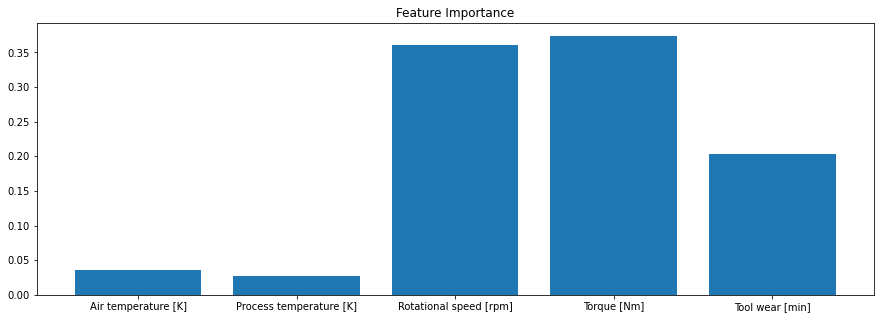

In [45]:
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("Feature Importance")

{'max_depth': 20, 'min_samples_split': 2}
Validation set score using predicted labels: 0.97
Calculated Validation set score: 0.05
Accuracy score :0.970
Confusion matrix :
[[1155   19]
 [  17   24]]


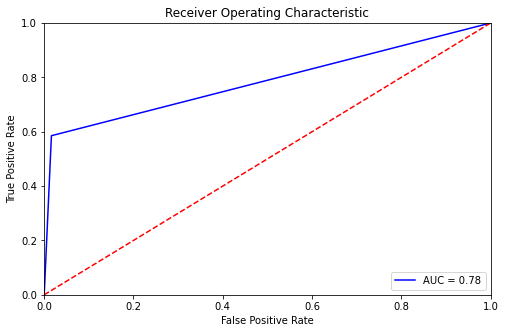

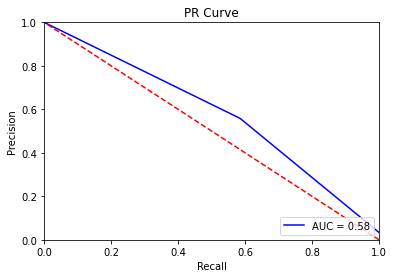

In [46]:
param_grid = {
    'max_depth' : [2,5,10,15,20],
    'min_samples_split' : [2,5,15],
    }

kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
dt = DecisionTreeClassifier(random_state = 111, class_weight = 'balanced')
grid_search = GridSearchCV(dt, param_grid, cv=kf, scoring = 'f1')
grid_search.fit(X_train_scaled, y_train)
#
print(grid_search.best_params_)
#
dt_best = grid_search.best_estimator_
dt_predictions = dt_best.predict(X_validation_scaled)
#
print("Validation set score using predicted labels: {:.2f}".format(np.mean(dt_predictions == y_validation)))

print("Calculated Validation set score: {:.2f}".format(dt_best.score(X_validation,y_validation)))

print("Accuracy score :{:.3f}".format(accuracy_score(y_validation,dt_predictions)))

print("Confusion matrix :\n{}".format(confusion_matrix(y_validation,dt_predictions)))
##
## Calculate the AUC and plot the ROC curve.
test_prob = dt_best.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix : 

[[1158   16]
 [  17   24]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1174
           1       0.60      0.59      0.59        41

    accuracy                           0.97      1215
   macro avg       0.79      0.79      0.79      1215
weighted avg       0.97      0.97      0.97      1215



Text(0.5, 1.0, 'DT Classifier Feature Importance')

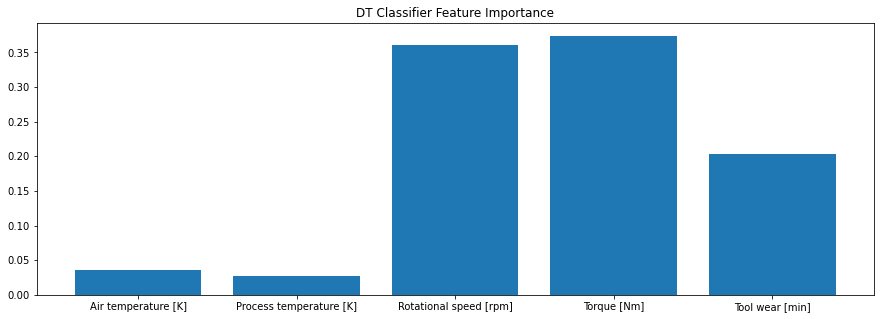

In [47]:
## DT with selected parameters 
dt = DecisionTreeClassifier(random_state = 12,class_weight = 'balanced', max_depth = 20 , min_samples_split = 2)
model = dt.fit(X_train_scaled,y_train)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation, validation_pred))
##
## feature importances
ft = model.feature_importances_
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("DT Classifier Feature Importance")

Confusion matrix : 

[[959   7]
 [ 15  19]]
Classification report : 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.73      0.56      0.63        34

    accuracy                           0.98      1000
   macro avg       0.86      0.78      0.81      1000
weighted avg       0.98      0.98      0.98      1000



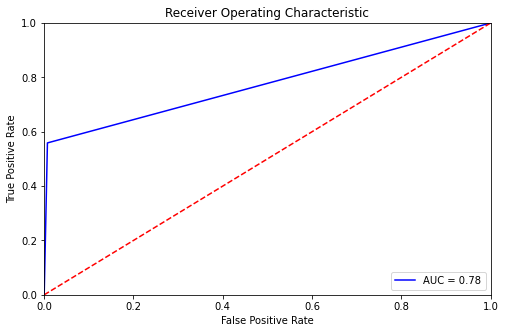

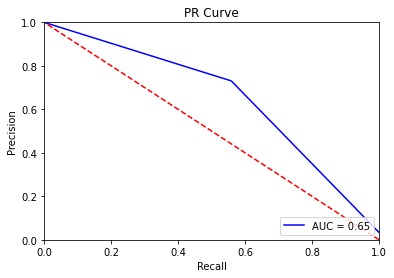

In [48]:
## On test data 
## Calculate the AUC and plot the ROC curve.
test_pred = model.predict(X_test_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_test_1,test_pred))
print("Classification report : \n")
print(classification_report(y_test_1,test_pred))
test_prob = model.predict_proba(X_test_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_test_1, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [49]:
classifier.append('DT')
pr.append(0.73)
rc.append(0.56)
f1_score.append(0.63)

[0.7027027  0.5840708  0.65486726 0.64761905 0.60194175]

 Avg f1 score :0.6382403101983822


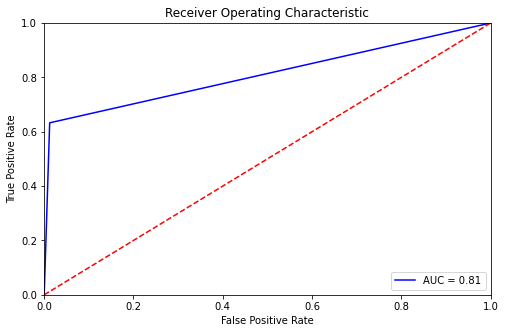

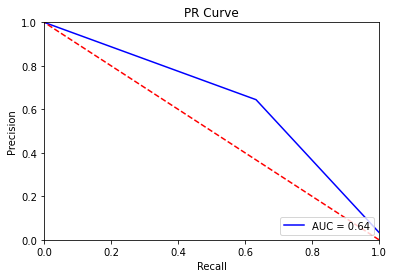

In [50]:
## Cross Validation 
dt = DecisionTreeClassifier(random_state = 12,class_weight = 'balanced', max_depth = 20 , min_samples_split = 2)
##
## scale the entire train data 
train_scaled = scaler.fit_transform(train_data[cols[3:8]])
target = train_data['Machine failure']
##
kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
scores = cross_val_score(dt , train_scaled , target , cv = kf,scoring = 'f1' )
print(scores)
print("\n Avg f1 score :{}".format(scores.mean()))
##

predicted = cross_val_predict(dt,  train_scaled , target , cv = kf, method = 'predict_proba' )
fpr, tpr, thresholds = roc_curve(target , predicted[:,1])
roc_auc = auc(fpr, tpr)
##
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(target , predicted[:,1])
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


In [51]:
## RandomForest Classifier 
from sklearn.ensemble import RandomForestClassifier
#
rf = RandomForestClassifier(random_state = 12,class_weight = 'balanced')
model = rf.fit(X_train_scaled,y_train)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))


Confusion matrix : 

[[1170    4]
 [  23   18]]
Classification report : 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1174
           1       0.82      0.44      0.57        41

    accuracy                           0.98      1215
   macro avg       0.90      0.72      0.78      1215
weighted avg       0.98      0.98      0.97      1215



Text(0.5, 1.0, 'RF Classifier Feature Importance')

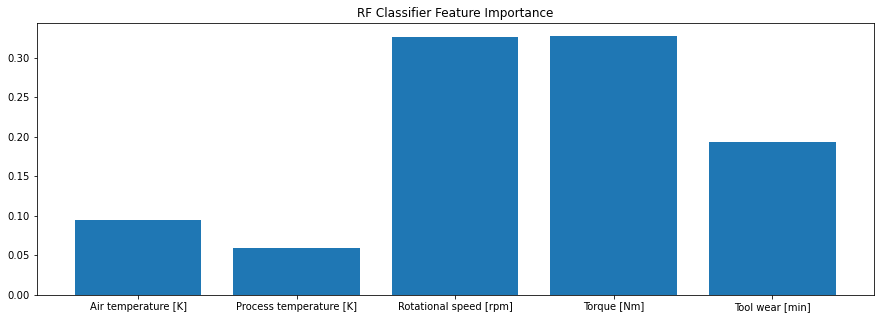

In [52]:
## feature importances
ft = model.feature_importances_
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("RF Classifier Feature Importance")

{'max_depth': 15, 'n_estimators': 800}
Validation set score using predicted labels: 0.97
Calculated Validation set score: 0.98
Accuracy score :0.970
Confusion matrix :
[[1155   19]
 [  17   24]]


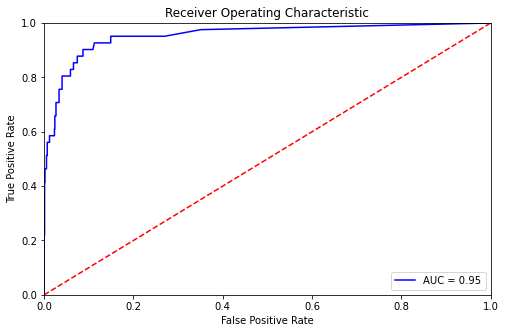

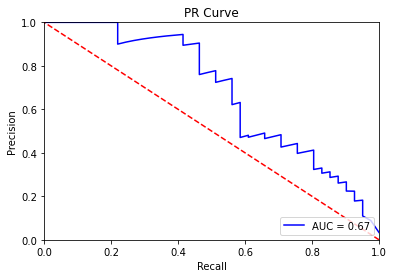

In [53]:
## GridSearchCV
param_grid = {
    'max_depth' : [2,5,10,15],
    'n_estimators' : [100,400,800],
    }
##
kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
rf = RandomForestClassifier(random_state = 12,class_weight = 'balanced')
grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring = 'f1')
grid_search.fit(X_train_scaled, y_train)
#
print(grid_search.best_params_)
#
rf_best = grid_search.best_estimator_
rf_predictions = dt_best.predict(X_validation_scaled)
#
print("Validation set score using predicted labels: {:.2f}".format(np.mean(rf_predictions == y_validation)))

print("Calculated Validation set score: {:.2f}".format(rf_best.score(X_validation_scaled,y_validation)))

print("Accuracy score :{:.3f}".format(accuracy_score(y_validation,rf_predictions)))

print("Confusion matrix :\n{}".format(confusion_matrix(y_validation,rf_predictions)))
##
## Calculate the AUC and plot the ROC curve.
test_prob = rf_best.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix : 

[[1171    3]
 [  22   19]]
Classification report : 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1174
           1       0.86      0.46      0.60        41

    accuracy                           0.98      1215
   macro avg       0.92      0.73      0.80      1215
weighted avg       0.98      0.98      0.98      1215



Text(0.5, 1.0, 'RF Classifier Feature Importance')

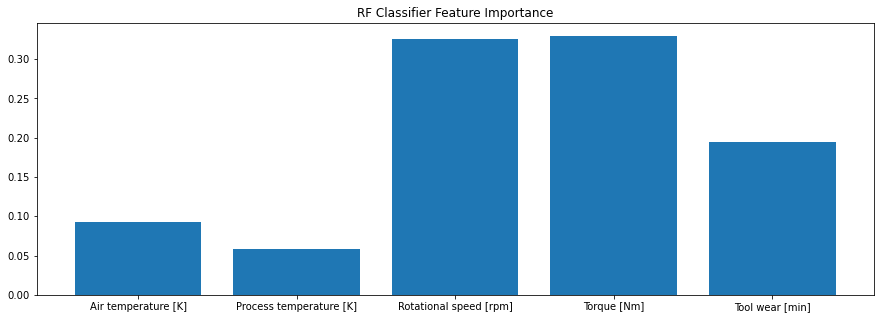

In [54]:
rf = RandomForestClassifier(random_state = 12,class_weight = 'balanced', max_depth = 15, n_estimators = 800)
model = rf.fit(X_train_scaled,y_train)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))
##
## feature importances
ft = model.feature_importances_
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("RF Classifier Feature Importance")

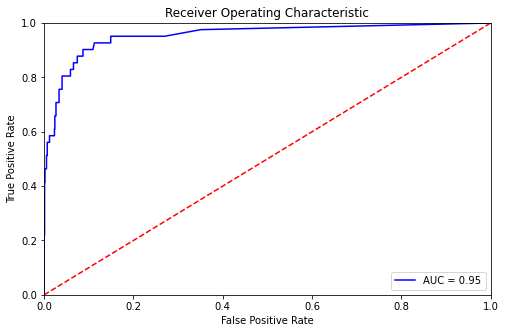

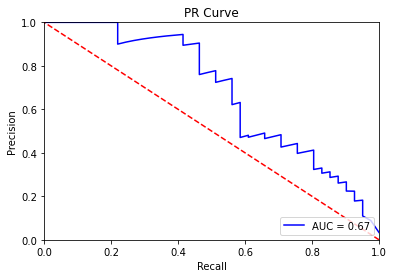

In [55]:
## Calculate the AUC and plot the ROC curve.
test_prob = model.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix : 

[[962   4]
 [ 15  19]]
Classification report : 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.83      0.56      0.67        34

    accuracy                           0.98      1000
   macro avg       0.91      0.78      0.83      1000
weighted avg       0.98      0.98      0.98      1000



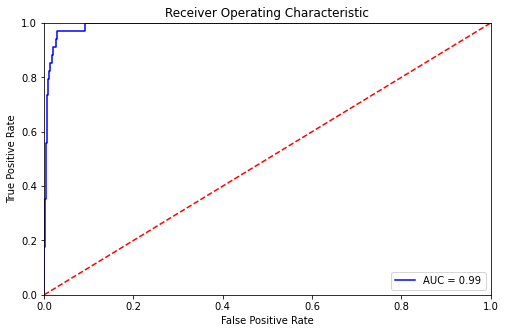

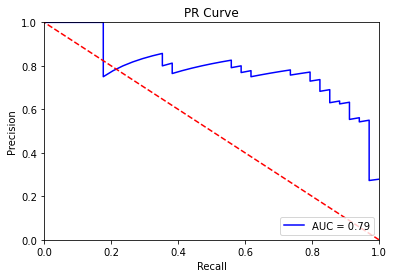

In [56]:
## on test data 

## Calculate the AUC and plot the ROC curve.
test_pred = model.predict(X_test_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_test_1,test_pred))
print("Classification report : \n")
print(classification_report(y_test_1,test_pred))
test_prob = model.predict_proba(X_test_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_test_1, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [57]:
classifier.append('RF')
pr.append(0.83)
rc.append(0.56)
f1_score.append(0.67)

[0.71578947 0.64285714 0.70212766 0.71111111 0.6097561 ]

 Avg f1 score :0.6763282969575817


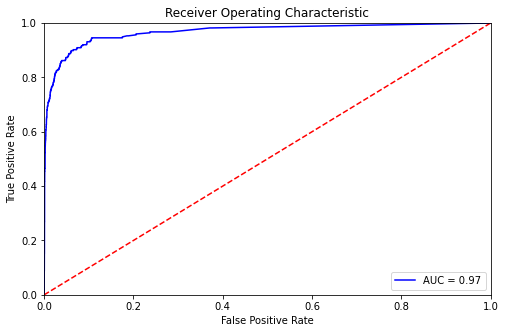

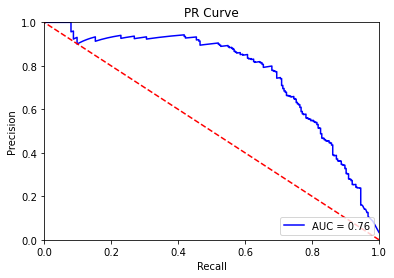

In [58]:
## Cross Validation 
rf = RandomForestClassifier(random_state = 12,class_weight = 'balanced', max_depth = 15, n_estimators = 800)
##
## scale the entire train data 
train_scaled = scaler.fit_transform(train_data[cols[3:8]])
predictors = train_data[cols[3:8]]
target = train_data['Machine failure']
##
kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
scores = cross_val_score(rf , predictors  , target , cv = kf,scoring = 'f1' )
print(scores)
print("\n Avg f1 score :{}".format(scores.mean()))
##

predicted = cross_val_predict(rf, predictors , target, cv = kf, method = 'predict_proba' )
fpr, tpr, thresholds = roc_curve(target, predicted[:,1])
roc_auc = auc(fpr, tpr)
##
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(target, predicted[:,1])
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


In [59]:
## Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

Confusion matrix : 

[[1171    3]
 [  18   23]]
Classification report : 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1174
           1       0.88      0.56      0.69        41

    accuracy                           0.98      1215
   macro avg       0.93      0.78      0.84      1215
weighted avg       0.98      0.98      0.98      1215



Text(0.5, 1.0, 'GBM Classifier Feature Importance')

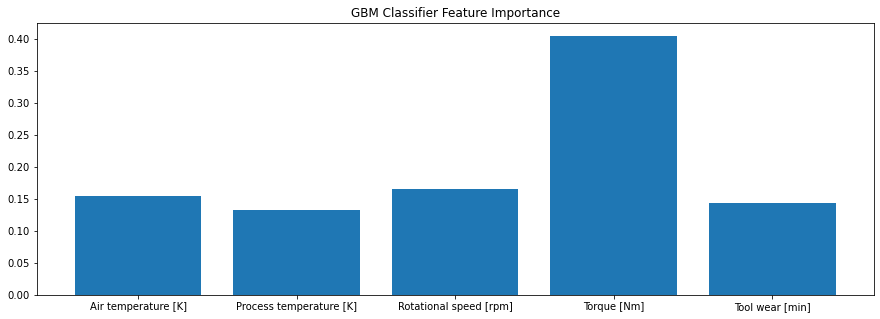

In [60]:
gbm = GradientBoostingClassifier(random_state = 123)
model = gbm.fit(X_train_scaled,y_train)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))
##
## feature importances
ft = model.feature_importances_
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("GBM Classifier Feature Importance")

{'learning_rate': 0.1, 'n_estimators': 400}
Test set score using predicted labels: 0.98
Calculated Test set score: 0.98
Accuracy score :0.982
Confusion matrix :
[[1171    3]
 [  19   22]]


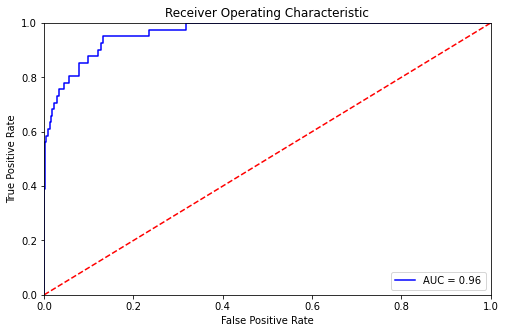

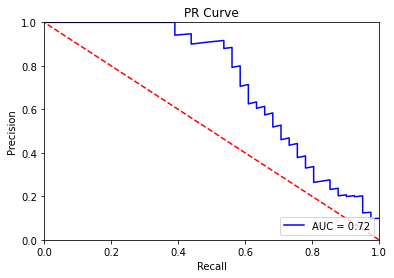

In [61]:
## Hyper parameter tuning

param_grid = {
    'learning_rate' : [0.01, 0.1,1],
    'n_estimators' : [100,400,800],
    }
gbm = GradientBoostingClassifier(random_state = 111)
kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
grid_search = GridSearchCV(gbm, param_grid, cv=kf, scoring = 'f1')
grid_search.fit(X_train_scaled, y_train)
#
print(grid_search.best_params_)
#
gbm_best = grid_search.best_estimator_
gbm_predictions = gbm_best.predict(X_validation_scaled)
#
print("Test set score using predicted labels: {:.2f}".format(np.mean(gbm_predictions == y_validation)))

print("Calculated Test set score: {:.2f}".format(gbm_best.score(X_validation_scaled,y_validation)))

print("Accuracy score :{:.3f}".format(accuracy_score(y_validation,gbm_predictions)))

print("Confusion matrix :\n{}".format(confusion_matrix(y_validation,gbm_predictions)))
##
## Calculate the AUC and plot the ROC curve.
test_prob = gbm_best.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix : 

[[1171    3]
 [  19   22]]
Classification report : 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1174
           1       0.88      0.54      0.67        41

    accuracy                           0.98      1215
   macro avg       0.93      0.77      0.83      1215
weighted avg       0.98      0.98      0.98      1215



Text(0.5, 1.0, 'GBM Classifier Feature Importance')

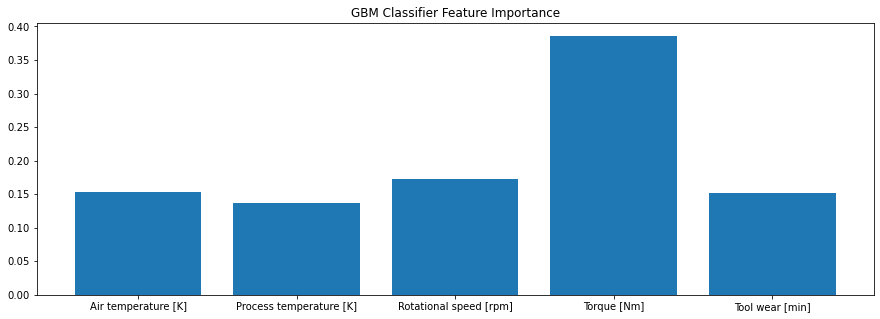

In [62]:
gbm = GradientBoostingClassifier(random_state = 123, learning_rate = 0.1 , n_estimators = 400)
model = gbm.fit(X_train_scaled,y_train)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))
##
## feature importances
ft = model.feature_importances_
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("GBM Classifier Feature Importance")

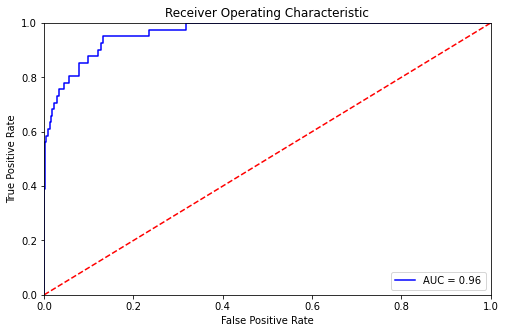

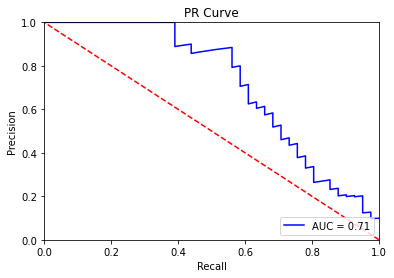

In [63]:
## Calculate the AUC and plot the ROC curve.
test_prob = model.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix for test data : 

[[961   5]
 [ 11  23]]
Classification report for test data : 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.82      0.68      0.74        34

    accuracy                           0.98      1000
   macro avg       0.91      0.84      0.87      1000
weighted avg       0.98      0.98      0.98      1000



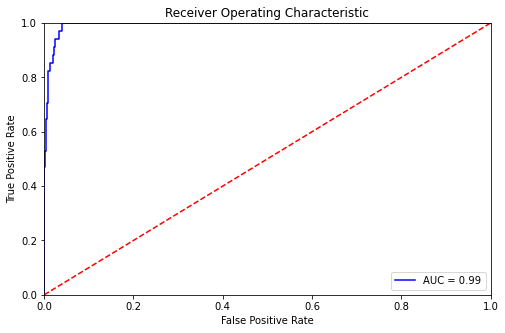

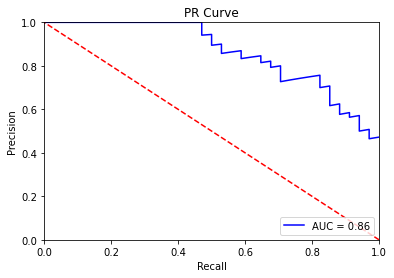

In [64]:
## on test data 
## Calculate the AUC and plot the ROC curve.
test_pred = model.predict(X_test_scaled)
print("Confusion matrix for test data : \n")
print(confusion_matrix(y_test_1,test_pred))
print("Classification report for test data : \n")
print(classification_report(y_test_1,test_pred))
test_prob = model.predict_proba(X_test_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_test_1, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [65]:
classifier.append('GBC')
pr.append(0.82)
rc.append(0.68)
f1_score.append(0.74)

[0.83809524 0.73786408 0.74747475 0.75510204 0.72527473]

 Avg f1 score :0.7607621658661882


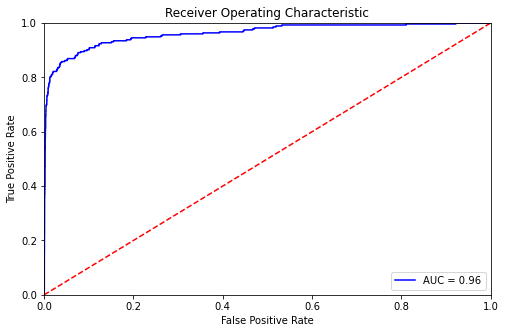

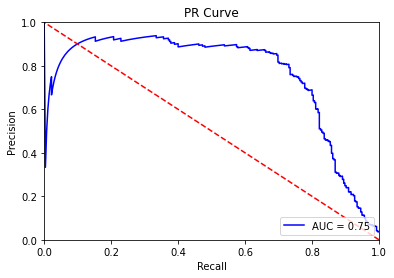

In [66]:
## Cross Validation 
gbm = GradientBoostingClassifier(random_state = 123, learning_rate = 0.1 , n_estimators = 400)
##
## scale the entire train data 
train_scaled = scaler.fit_transform(train_data[cols[3:8]])
predictors = train_data[cols[3:8]]
target = train_data['Machine failure']
##
kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
scores = cross_val_score(gbm , predictors , target , cv = kf,scoring = 'f1' )
print(scores)
print("\n Avg f1 score :{}".format(scores.mean()))
##

predicted = cross_val_predict(gbm, predictors , target, cv = kf, method = 'predict_proba' )
fpr, tpr, thresholds = roc_curve(target, predicted[:,1])
roc_auc = auc(fpr, tpr)
##
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(target, predicted[:,1])
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
Test set score using predicted labels: 0.82
Calculated Test set score: 0.82
Accuracy score :0.816
Confusion matrix :
[[959 215]
 [  8  33]]


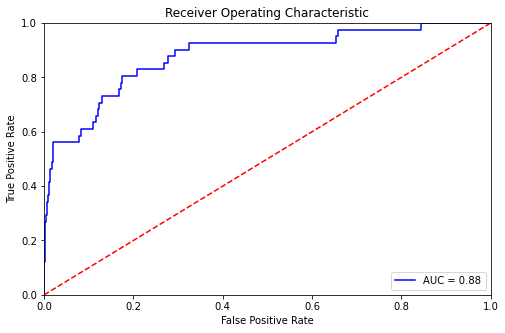

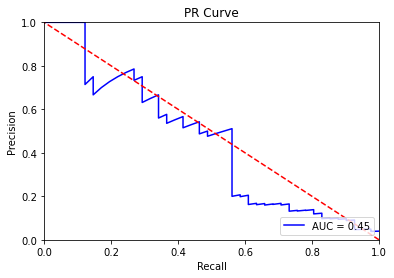

In [67]:
from sklearn.svm import SVC
param_grid = {
    'C' : [0.01,0.1,1],
    'kernel' : ['linear'],
    'gamma' : ['auto']
    }
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 33)
svm = SVC(random_state = 111, class_weight = 'balanced', probability = True )
grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring = 'f1')
grid_search.fit(X_train_scaled, y_train)
#
print(grid_search.best_params_)
#
svm_best = grid_search.best_estimator_
svm_predictions = svm_best.predict(X_validation_scaled)
#
print("Test set score using predicted labels: {:.2f}".format(np.mean(svm_predictions == y_validation)))

print("Calculated Test set score: {:.2f}".format(svm_best.score(X_validation_scaled,y_validation)))

print("Accuracy score :{:.3f}".format(accuracy_score(y_validation,svm_predictions)))

print("Confusion matrix :\n{}".format(confusion_matrix(y_validation,svm_predictions)))
##
## Calculate the AUC and plot the ROC curve.
test_prob = svm_best.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix : 

[[959 215]
 [  8  33]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1174
           1       0.13      0.80      0.23        41

    accuracy                           0.82      1215
   macro avg       0.56      0.81      0.56      1215
weighted avg       0.96      0.82      0.87      1215



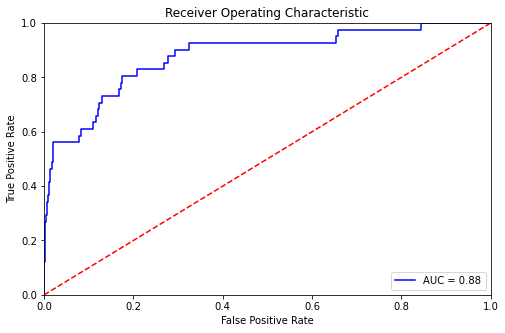

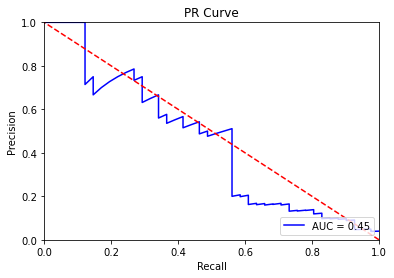

In [68]:
svm = SVC(random_state = 123, C = 1, gamma = 'auto', kernel = 'linear',class_weight = 'balanced', probability = True)
model = svm.fit(X_train_scaled,y_train)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))
##
## Calculate the AUC and plot the ROC curve.
test_prob = model.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix for test data : 

[[801 165]
 [  4  30]]
Classification report for test data : 

              precision    recall  f1-score   support

           0       1.00      0.83      0.90       966
           1       0.15      0.88      0.26        34

    accuracy                           0.83      1000
   macro avg       0.57      0.86      0.58      1000
weighted avg       0.97      0.83      0.88      1000



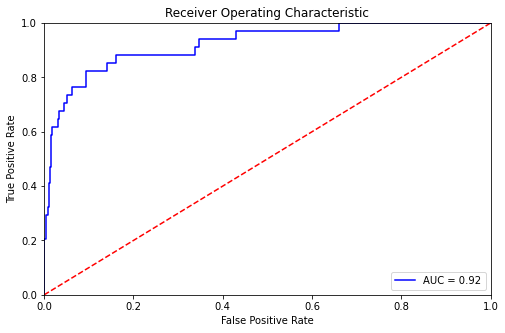

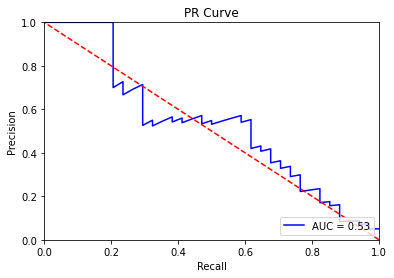

In [69]:
## on test data 
## Calculate the AUC and plot the ROC curve.
test_pred = model.predict(X_test_scaled)
print("Confusion matrix for test data : \n")
print(confusion_matrix(y_test_1,test_pred))
print("Classification report for test data : \n")
print(classification_report(y_test_1,test_pred))
test_prob = model.predict_proba(X_test_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_test_1, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [70]:
classifier.append('SVC')
pr.append(0.15)
rc.append(0.88)
f1_score.append(0.26)

In [71]:
results = {}
results['classifier'] = classifier
results['pr'] = pr
results['recall'] = rc
results['f1_score'] = f1_score
results_df = pd.DataFrame(results)
results_df.set_index('classifier', inplace = True)

In [72]:
results_df

,pr,recall,f1_score
classifier,,,
Logistic Regression,0.00,0.00,0.00
DT,0.73,0.56,0.63
RF,0.83,0.56,0.67
GBC,0.82,0.68,0.74
SVC,0.15,0.88,0.26


Gradient Boosting Classifier has given the best F1 score of 0.74. Precision is the highest at 0.82 and Recall is 0.68.  
11 out of 34 failures are mis-classified and 5 out of 966 non-failures are classified as failures.  
Torque and Tool Wear are the important variable that 

### Understanding the machine sub failures prediction 

In [74]:
## Check the test data for prediction using the best classifier Gradient Boosting Classifier

gbm = GradientBoostingClassifier(random_state = 123, learning_rate = 0.1 , n_estimators = 400)
model = gbm.fit(X_train_scaled,y_train)
test_pred = model.predict(X_test_scaled)
##
evaluate_test = test_data_1.copy()
evaluate_test['predicted'] = test_pred

In [37]:
## save the model 
import pickle
pickle.dump(model, open('pm_ai2020_model_1.sav' , 'wb'))

In [75]:
evaluate_test

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,predicted
5019,5020,M19879,M,304.0,313.1,1466,39.5,83,0,0,0,0,0,0,0
5324,5325,M20184,M,303.4,312.8,1526,30.8,37,0,0,0,0,0,0,0
8518,8519,M23378,M,298.3,309.6,1681,27.1,194,0,0,0,0,0,0,0
3341,3342,H32755,H,301.4,310.7,1329,52.0,160,0,0,0,0,0,0,0
6300,6301,L53480,L,301.2,310.7,1517,39.4,107,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6497,6498,L53677,L,300.8,309.9,1312,65.3,192,1,0,0,0,1,0,1
4643,4644,L51823,L,303.2,311.4,1324,54.2,228,1,0,1,0,1,0,1
4501,4502,L51681,L,302.5,310.2,1307,54.0,86,1,0,1,0,0,0,1
4851,4852,L52031,L,303.7,312.1,1363,51.8,90,1,0,1,0,0,0,0


In [76]:
wrong_predictions_df = evaluate_test[evaluate_test['predicted'] != evaluate_test['Machine failure']]

In [77]:
wrong_predictions_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,predicted
4231,4232,L51411,L,302.2,310.8,1340,47.8,54,0,0,0,0,0,0,1
4070,4071,L51250,L,302.0,310.7,1348,58.1,83,0,0,0,0,0,0,1
3809,3810,L50989,L,302.2,310.8,1350,56.6,76,0,0,0,0,0,0,1
3387,3388,M18247,M,301.6,310.8,1290,65.3,63,0,0,0,0,0,0,1
1332,1333,L48512,L,299.0,310.3,1868,24.0,221,0,0,0,0,0,0,1


Text(0.5, 1.0, 'Torque values in test data ')

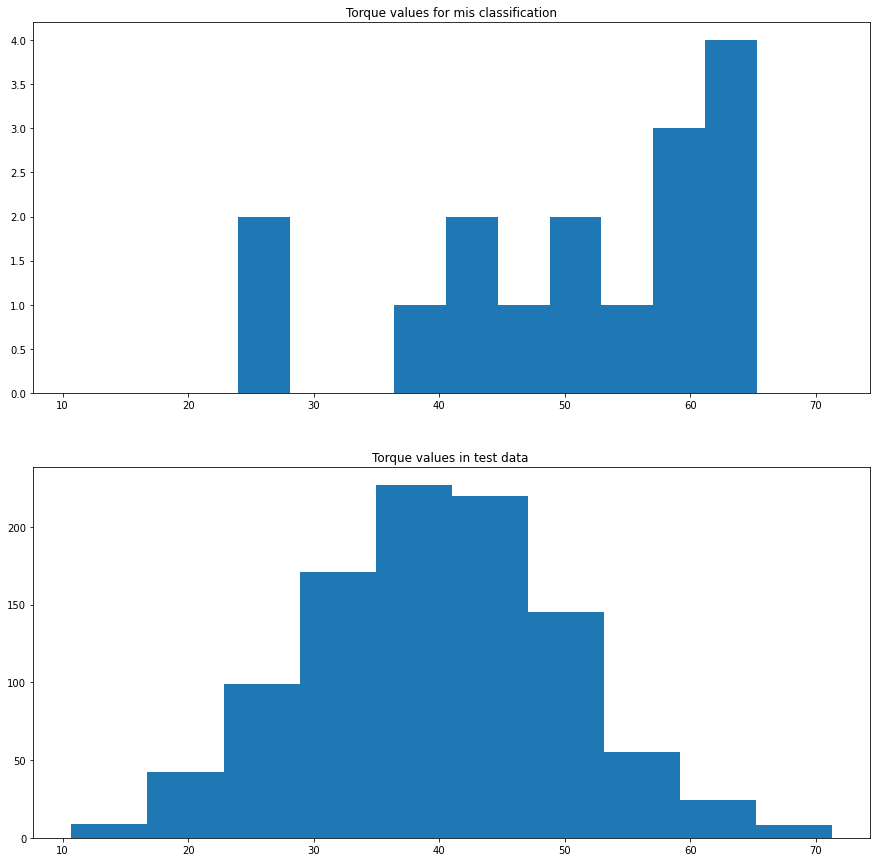

In [81]:
## Plot the values 
plt.figure(figsize = (15,15))
ax1 = plt.subplot(2,1,1)
plt.hist(wrong_predictions_df[cols[6]])
plt.title('Torque values for mis classification')
ax2 = plt.subplot(2,1,2 , sharex =ax1)
plt.hist(test_data_1[cols[6]] )
plt.title('Torque values in test data ')


Text(0.5, 1.0, 'Tool wear values in test data ')

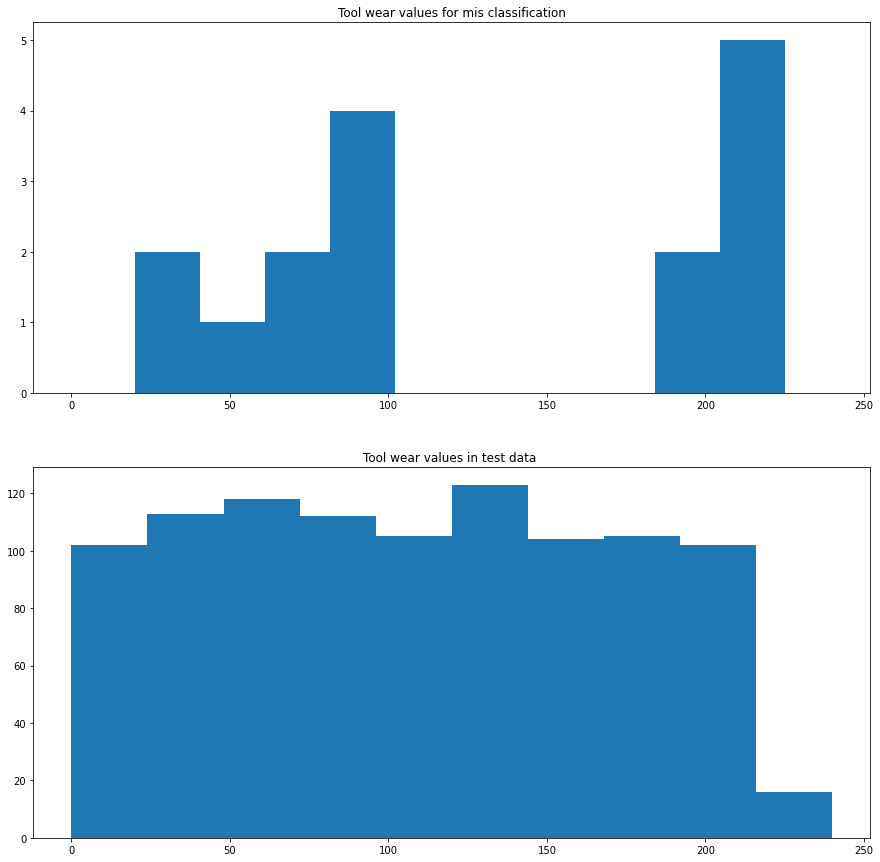

In [82]:
## Plot the values 
plt.figure(figsize = (15,15))
ax1 = plt.subplot(2,1,1)
plt.hist(wrong_predictions_df[cols[7]])
plt.title('Tool wear values for mis classification')
ax2 = plt.subplot(2,1,2 , sharex =ax1)
plt.hist(test_data_1[cols[7]] )
plt.title('Tool wear values in test data ')

In [83]:
## How many sub failures were correctly predicted and not correctly predicted ? 


In [84]:
def get_count(df):
    
    print(df['TWF'].value_counts())
    ##
    print(df['HDF'].value_counts())
    ##
    print(df['PWF'].value_counts())
    ##
    print(df['OSF'].value_counts())
    ##
    print(df['RNF'].value_counts())
    
    return

In [85]:
get_count(wrong_predictions_df)

0    13
1     3
Name: TWF, dtype: int64
0    11
1     5
Name: HDF, dtype: int64
0    16
Name: PWF, dtype: int64
0    13
1     3
Name: OSF, dtype: int64
0    16
Name: RNF, dtype: int64


Among the wrong predictions, HDF - heat dissipation failure has 5, followed by 3 of TWF -Tool wear failure and OSF- OverStrain Failure.

In [86]:
correct_predictions_df = evaluate_test[evaluate_test['predicted'] == evaluate_test['Machine failure']]
correct_predictions_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,predicted
5019,5020,M19879,M,304.0,313.1,1466,39.5,83,0,0,0,0,0,0,0
5324,5325,M20184,M,303.4,312.8,1526,30.8,37,0,0,0,0,0,0,0
8518,8519,M23378,M,298.3,309.6,1681,27.1,194,0,0,0,0,0,0,0
3341,3342,H32755,H,301.4,310.7,1329,52.0,160,0,0,0,0,0,0,0
6300,6301,L53480,L,301.2,310.7,1517,39.4,107,0,0,0,0,0,0,0


In [87]:
get_count(correct_predictions_df)

0    984
Name: TWF, dtype: int64
0    976
1      8
Name: HDF, dtype: int64
0    975
1      9
Name: PWF, dtype: int64
0    977
1      7
Name: OSF, dtype: int64
0    983
1      1
Name: RNF, dtype: int64


Model has predicted correctly :  
0 of the 3 TWF failures,   
8 of 13 HDF failures,  
All the 9 PWF failures,  
7 of 10 OSF failures.  
